# Time Series Forecasting with TensorFlow

### Contents of this notebook
  * Get the time series data
    * Load the time series data using Pandas/Python,s CSV module
  * Format data for a time series problem
    * Creating training and test sets (the wrong way)
    * Creating training and test sets (the right way)
    * Visualizing time series data
    * Turning time series data into a supervised learning problem (windowing)
    * Preparing univariate and multivariate
  * Evaluating a time series forecasting model
  * Setting up a series of deep learning modelling experiments
    * Dense (fully-connected) networks
    * Sequence models (LSTM and 1D CNN)
    * Ensembling (combining multiple models together)
    * Multivariate models
    * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
  * Creating a model checkpoint to save the best performing model during training
  * Making predictions (forecasts) with a time series model
  * Creating prediction intervals for the time series model forecasts
  * Discussing two different types of uncertainity in machine learning (data uncertainity and model uncertainity)
  * Demonstrating why forecasting in an open system is BS (the turkey problem)

### Check for GPU

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-701667f9-5738-1474-9421-d4cebf87f4b4)


## Get data

In [2]:
# Download Bitcoin historical data from GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-03-02 05:38:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2023-03-02 05:38:29 (7.13 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series data with pandas

In [3]:
# Import with pandas
import pandas as pd
import numpy as np
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])

In [4]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [6]:
df.shape

(2787, 5)

In [7]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


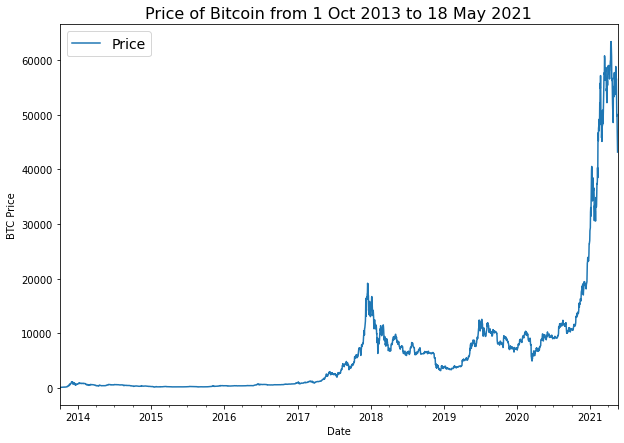

In [8]:
# Visulaizing data
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.legend(fontsize=14)

### Importing time series data with Python's CSV module

In [9]:
# Importing and formatting historical Bitcoin data with Python

import csv
from datetime import datetime

timesteps = []
btc_price = []
with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv') as f:
  csv_reader = csv.reader(f, delimiter=',')
  next(csv_reader)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))

# View first 10 of each

timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 0, 'Date')

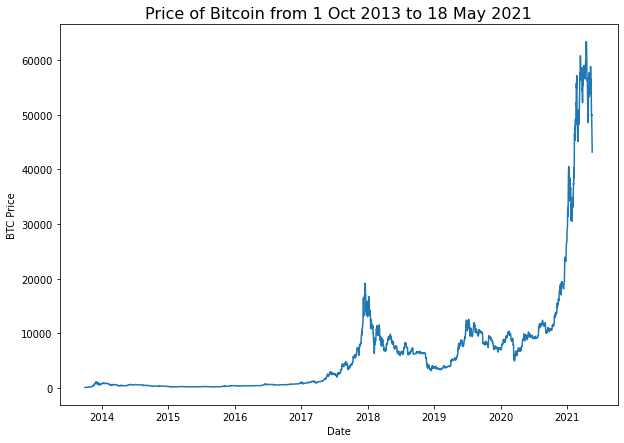

In [10]:
# Plot from CSV
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.xlabel('Date')

## Formatting data for time series problem

### Creating train and test sets for time series data (the wrong way)

In [11]:
# Get Bitcoin date array

timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [12]:
# Wrong way to make train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

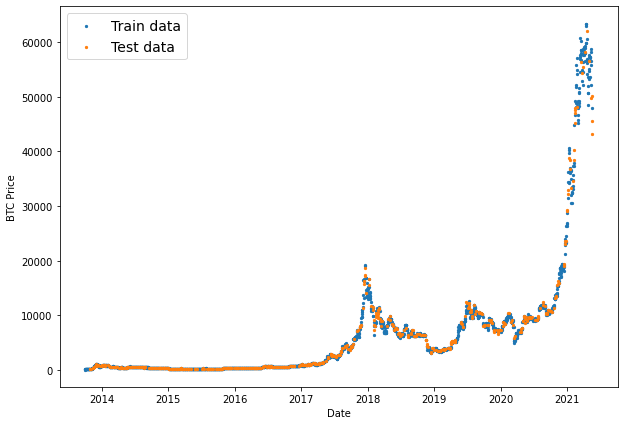

In [13]:
# Plotting wrong train and test splits

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Creating train and test sets for time series data (the right way)

In [14]:
split_size = int(0.8 * len(prices))

X_train, y_train = timesteps[0:split_size], prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

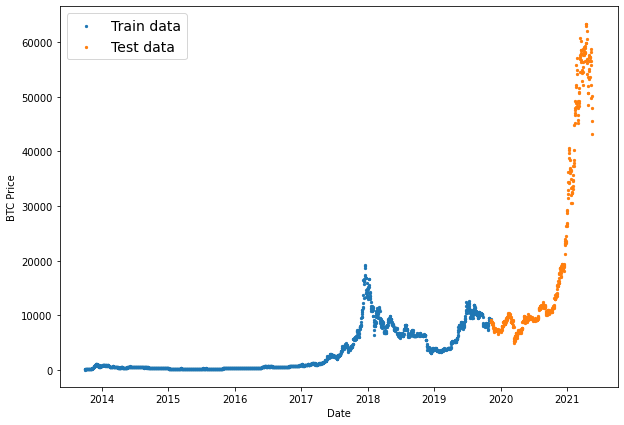

In [15]:
# Plot correctly made splits

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Creating a plotting function

In [16]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True) 

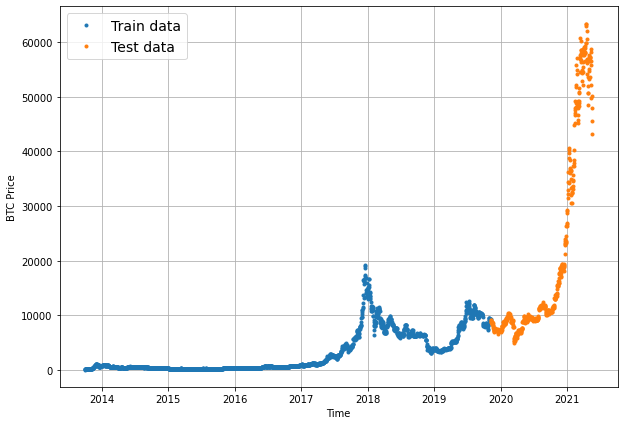

In [17]:
# Try out our plotting function

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')

## Modelling Experiments

### Model 0: Naive Forecast (baseline)

In [18]:
# Create a naive forecast

naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

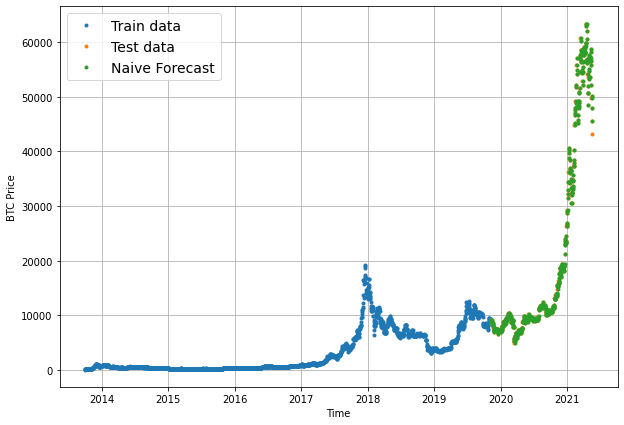

In [19]:
# Plot naive forecast

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, label='Naive Forecast')

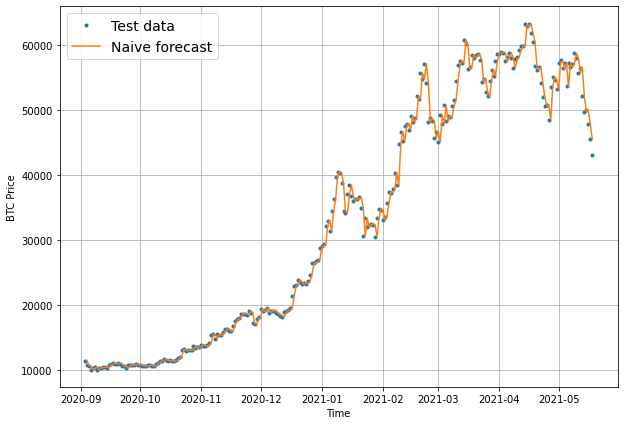

In [20]:
# Zooming in the plot

plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(timesteps=X_test, values=y_test, start=offset, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, format='-', label='Naive forecast')


### Evaluating a time series model

In [21]:
import tensorflow as tf

In [22]:
# Create a function to calculate MASE (mean absolute scaled error)

def mean_absolute_scaled_error(y_true, y_pred):
  
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
  
  return mae/mae_naive_no_season

In [23]:
# Create a function to calculate results (predictions)

def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

### Other models/libraries for time series forecasting
  * Moving average
  * ARIMA (AutoRegression Integrated Moving Average)
  * Sktime (Scikit-learn for time series)
  * TensorFlow Decision Forecasts (random forest, gradient boosting trees)
  * Facebook Kats (purpose built forecasting and time series analysis library by facebook)
  * LinkedIn Greykite (flexible, intuitive and fast forecasts)


### Windowing dataset

In [25]:
HORIZON = 1           # Predict 1 step at a time
WINDOW_SIZE = 7       # Use a week worth of timestamps to predict the horizon

In [26]:
# Create a function to label windowed data

def get_labelled_windows(x, horizon=1):

  return x[:,:-horizon], x[:,-horizon:]

In [27]:
# Test out the window labelling function

test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {test_window} -> Label: {test_label}")

Window: [[1 2 3 4 5 6 7]] -> Label: [[8]]


In [28]:
# Create a function to view NumPy arrays as windows

def make_windows(x, window_size=7, horizon=1):

  # 1. Create a window of specific window size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for zero indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [29]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [30]:
# View the first three windows/labels

for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


### Turning windows into training and test sets

In [31]:
# Make the train test split

def make_train_test_split(windows, labels, test_split=0.2):

  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [32]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [33]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

### Make modelling checkpoint

In [34]:
import os

# Create a function ti implement model checkpoint callback with a specific filename

def create_model_checkpoint(model_name, save_path="model_experiments"):
  
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

### Model 1: Dense model (window = 7, horizon = 1)

In [35]:
import tensorflow as tf
from tensorflow.keras import layers

# Set seed
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
12/18 [===================>..........] - ETA: 0s - loss: 2476.9292 - mae: 2476.9292  

18/18 [==============================] - 7s 108ms/step - loss: 1947.2305 - mae: 1947.2305 - val_loss: 1044.5790 - val_mae: 1044.5790
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 378.9498 - mae: 378.9498 - val_loss: 1735.2070 - val_mae: 1735.2070
Epoch 3/100
18/18 [==============================] - 0s 17ms/step - loss: 236.4646 - mae: 236.4646 - val_loss: 1064.8657 - val_mae: 1064.8657
Epoch 4/100
17/18 [===========================>..] - ETA: 0s - loss: 191.6989 - mae: 191.6989

18/18 [==============================] - 2s 111ms/step - loss: 190.1012 - mae: 190.1012 - val_loss: 1007.8514 - val_mae: 1007.8514
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 180.8363 - mae: 180.8363 - val_loss: 1024.0829 - val_mae: 1024.0829
Epoch 6/100
12/18 [===================>..........] - ETA: 0s - loss: 171.9267 - mae: 171.9267

18/18 [==============================] - 1s 55ms/step - loss: 174.1333 - mae: 174.1333 - val_loss: 953.3743 - val_mae: 953.3743
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 169.7044 - mae: 169.7044 - val_loss: 953.8622 - val_mae: 953.8622
Epoch 8/100
11/18 [=================>............] - ETA: 0s - loss: 163.0294 - mae: 163.0294

18/18 [==============================] - 1s 78ms/step - loss: 166.2113 - mae: 166.2113 - val_loss: 918.4395 - val_mae: 918.4395
Epoch 9/100
18/18 [==============================] - 0s 15ms/step - loss: 165.6984 - mae: 165.6984 - val_loss: 948.5614 - val_mae: 948.5614
Epoch 10/100
11/18 [=================>............] - ETA: 0s - loss: 158.9227 - mae: 158.9227

18/18 [==============================] - 1s 70ms/step - loss: 162.9008 - mae: 162.9008 - val_loss: 899.2650 - val_mae: 899.2650
Epoch 11/100
 9/18 [==============>...............] - ETA: 0s - loss: 155.0539 - mae: 155.0539

18/18 [==============================] - 2s 90ms/step - loss: 160.0114 - mae: 160.0114 - val_loss: 871.8011 - val_mae: 871.8011
Epoch 12/100
18/18 [==============================] - 0s 10ms/step - loss: 154.9881 - mae: 154.9881 - val_loss: 895.8453 - val_mae: 895.8453
Epoch 13/100
18/18 [==============================] - 0s 10ms/step - loss: 153.7686 - mae: 153.7686 - val_loss: 888.3965 - val_mae: 888.3965
Epoch 14/100
13/18 [====================>.........] - ETA: 0s - loss: 146.6189 - mae: 146.6189

18/18 [==============================] - 1s 74ms/step - loss: 150.1820 - mae: 150.1820 - val_loss: 806.1130 - val_mae: 806.1130
Epoch 15/100
13/18 [====================>.........] - ETA: 0s - loss: 140.4278 - mae: 140.4278

18/18 [==============================] - 1s 75ms/step - loss: 145.6185 - mae: 145.6185 - val_loss: 784.6008 - val_mae: 784.6008
Epoch 16/100
18/18 [==============================] - 0s 9ms/step - loss: 141.7874 - mae: 141.7874 - val_loss: 806.3214 - val_mae: 806.3214
Epoch 17/100
18/18 [==============================] - 0s 9ms/step - loss: 140.2519 - mae: 140.2519 - val_loss: 810.5737 - val_mae: 810.5737
Epoch 18/100
12/18 [===================>..........] - ETA: 0s - loss: 146.7832 - mae: 146.7832

18/18 [==============================] - 1s 66ms/step - loss: 140.3080 - mae: 140.3080 - val_loss: 771.9237 - val_mae: 771.9238
Epoch 19/100
10/18 [===============>..............] - ETA: 0s - loss: 132.0218 - mae: 132.0218

18/18 [==============================] - 2s 135ms/step - loss: 136.2285 - mae: 136.2285 - val_loss: 753.8854 - val_mae: 753.8854
Epoch 20/100
11/18 [=================>............] - ETA: 0s - loss: 142.3166 - mae: 142.3166

18/18 [==============================] - 1s 60ms/step - loss: 139.4231 - mae: 139.4231 - val_loss: 725.4822 - val_mae: 725.4822
Epoch 21/100
16/18 [=========================>....] - ETA: 0s - loss: 139.9233 - mae: 139.9233

18/18 [==============================] - 1s 72ms/step - loss: 140.8497 - mae: 140.8497 - val_loss: 719.1765 - val_mae: 719.1765
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 189.5149 - mae: 189.5149

18/18 [==============================] - 1s 58ms/step - loss: 132.8316 - mae: 132.8316 - val_loss: 709.3670 - val_mae: 709.3670
Epoch 23/100
14/18 [======================>.......] - ETA: 0s - loss: 127.9141 - mae: 127.9141

18/18 [==============================] - 1s 52ms/step - loss: 130.2936 - mae: 130.2936 - val_loss: 705.8005 - val_mae: 705.8005
Epoch 24/100
15/18 [========================>.....] - ETA: 0s - loss: 129.2860 - mae: 129.2860

18/18 [==============================] - 1s 65ms/step - loss: 128.8589 - mae: 128.8589 - val_loss: 696.4826 - val_mae: 696.4826
Epoch 25/100
13/18 [====================>.........] - ETA: 0s - loss: 132.8574 - mae: 132.8574

18/18 [==============================] - 1s 80ms/step - loss: 129.4820 - mae: 129.4820 - val_loss: 688.0772 - val_mae: 688.0772
Epoch 26/100
18/18 [==============================] - ETA: 0s - loss: 127.8061 - mae: 127.8061

18/18 [==============================] - 1s 47ms/step - loss: 127.8061 - mae: 127.8061 - val_loss: 681.2709 - val_mae: 681.2709
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 182.7895 - mae: 182.7895

18/18 [==============================] - 1s 52ms/step - loss: 127.5724 - mae: 127.5724 - val_loss: 678.1122 - val_mae: 678.1122
Epoch 28/100
18/18 [==============================] - 0s 11ms/step - loss: 127.1358 - mae: 127.1358 - val_loss: 691.6887 - val_mae: 691.6887
Epoch 29/100
18/18 [==============================] - 0s 9ms/step - loss: 127.4957 - mae: 127.4957 - val_loss: 737.0427 - val_mae: 737.0427
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 134.4283 - mae: 134.4283 - val_loss: 740.7463 - val_mae: 740.7463
Epoch 31/100
18/18 [==============================] - 0s 8ms/step - loss: 142.9355 - mae: 142.9355 - val_loss: 898.9730 - val_mae: 898.9730
Epoch 32/100
10/18 [===============>..............] - ETA: 0s - loss: 144.4943 - mae: 144.4943

18/18 [==============================] - 1s 43ms/step - loss: 138.6388 - mae: 138.6388 - val_loss: 661.0238 - val_mae: 661.0238
Epoch 33/100
18/18 [==============================] - 0s 16ms/step - loss: 124.4479 - mae: 124.4479 - val_loss: 684.1182 - val_mae: 684.1182
Epoch 34/100
12/18 [===================>..........] - ETA: 0s - loss: 127.7432 - mae: 127.7432

18/18 [==============================] - 3s 166ms/step - loss: 123.4068 - mae: 123.4068 - val_loss: 651.4846 - val_mae: 651.4846
Epoch 35/100
13/18 [====================>.........] - ETA: 0s - loss: 124.6525 - mae: 124.6525

18/18 [==============================] - 1s 66ms/step - loss: 120.5317 - mae: 120.5317 - val_loss: 647.2302 - val_mae: 647.2302
Epoch 36/100
18/18 [==============================] - 0s 10ms/step - loss: 125.3214 - mae: 125.3214 - val_loss: 684.3837 - val_mae: 684.3837
Epoch 37/100
18/18 [==============================] - 0s 10ms/step - loss: 122.1343 - mae: 122.1343 - val_loss: 657.1744 - val_mae: 657.1744
Epoch 38/100
14/18 [======================>.......] - ETA: 0s - loss: 124.2836 - mae: 124.2836

18/18 [==============================] - 1s 73ms/step - loss: 120.2382 - mae: 120.2382 - val_loss: 643.0521 - val_mae: 643.0521
Epoch 39/100
18/18 [==============================] - 0s 18ms/step - loss: 120.4799 - mae: 120.4799 - val_loss: 693.8040 - val_mae: 693.8040
Epoch 40/100
18/18 [==============================] - ETA: 0s - loss: 118.7365 - mae: 118.7365

18/18 [==============================] - 1s 72ms/step - loss: 118.7365 - mae: 118.7365 - val_loss: 635.0573 - val_mae: 635.0573
Epoch 41/100
11/18 [=================>............] - ETA: 0s - loss: 122.6671 - mae: 122.6671

18/18 [==============================] - 1s 55ms/step - loss: 117.6348 - mae: 117.6348 - val_loss: 632.9391 - val_mae: 632.9391
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 119.7521 - mae: 119.7521 - val_loss: 648.8006 - val_mae: 648.8006
Epoch 43/100
18/18 [==============================] - 0s 7ms/step - loss: 120.5554 - mae: 120.5554 - val_loss: 645.3214 - val_mae: 645.3214
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 123.8466 - mae: 123.8466 - val_loss: 640.3656 - val_mae: 640.3656
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 115.9845 - mae: 115.9845 - val_loss: 642.6685 - val_mae: 642.6685
Epoch 46/100
16/18 [=========================>....] - ETA: 0s - loss: 118.2179 - mae: 118.2179

18/18 [==============================] - 1s 73ms/step - loss: 117.1712 - mae: 117.1712 - val_loss: 623.9739 - val_mae: 623.9739
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 114.9588 - mae: 114.9588 - val_loss: 636.8239 - val_mae: 636.8239
Epoch 48/100
18/18 [==============================] - 0s 11ms/step - loss: 114.5281 - mae: 114.5281 - val_loss: 626.0228 - val_mae: 626.0228
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 115.0658 - mae: 115.0658 - val_loss: 686.1486 - val_mae: 686.1486
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 125.0952 - mae: 125.0952 - val_loss: 688.2225 - val_mae: 688.2225
Epoch 51/100
18/18 [==============================] - 0s 9ms/step - loss: 115.7648 - mae: 115.7648 - val_loss: 632.7682 - val_mae: 632.7682
Epoch 52/100
18/18 [==============================] - 0s 12ms/step - loss: 115.4334 - mae: 115.4334 - val_loss: 667.6946 - val_mae: 667.6946
Epoch 53/100
18/18 [==========

18/18 [==============================] - 1s 55ms/step - loss: 116.5707 - mae: 116.5707 - val_loss: 607.8711 - val_mae: 607.8711
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 114.8919 - mae: 114.8919 - val_loss: 752.6774 - val_mae: 752.6774
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 132.4744 - mae: 132.4744 - val_loss: 797.3839 - val_mae: 797.3839
Epoch 58/100
18/18 [==============================] - 0s 7ms/step - loss: 128.1575 - mae: 128.1575 - val_loss: 710.5883 - val_mae: 710.5883
Epoch 59/100
18/18 [==============================] - 0s 5ms/step - loss: 113.8204 - mae: 113.8204 - val_loss: 618.1483 - val_mae: 618.1483
Epoch 60/100
18/18 [==============================] - 0s 6ms/step - loss: 112.6458 - mae: 112.6458 - val_loss: 627.4844 - val_mae: 627.4844
Epoch 61/100
18/18 [==============================] - ETA: 0s - loss: 111.4860 - mae: 111.4860

18/18 [==============================] - 2s 118ms/step - loss: 111.4860 - mae: 111.4860 - val_loss: 600.5588 - val_mae: 600.5588
Epoch 62/100
14/18 [======================>.......] - ETA: 0s - loss: 110.3021 - mae: 110.3021

18/18 [==============================] - 2s 92ms/step - loss: 109.7510 - mae: 109.7510 - val_loss: 600.1334 - val_mae: 600.1334
Epoch 63/100
18/18 [==============================] - 0s 8ms/step - loss: 112.4337 - mae: 112.4337 - val_loss: 624.3583 - val_mae: 624.3583
Epoch 64/100
18/18 [==============================] - 0s 11ms/step - loss: 112.1249 - mae: 112.1249 - val_loss: 605.1838 - val_mae: 605.1838
Epoch 65/100
18/18 [==============================] - 0s 7ms/step - loss: 110.2743 - mae: 110.2743 - val_loss: 621.5535 - val_mae: 621.5535
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 109.8986 - mae: 109.8986 - val_loss: 602.4545 - val_mae: 602.4545
Epoch 67/100
18/18 [==============================] - 0s 7ms/step - loss: 110.4989 - mae: 110.4989 - val_loss: 678.9890 - val_mae: 678.9890
Epoch 68/100
18/18 [==============================] - 0s 9ms/step - loss: 116.8033 - mae: 116.8033 - val_loss: 718.9506 - val_mae: 718.9506
Epoch 69/100
18/18 [===========

18/18 [==============================] - 1s 54ms/step - loss: 123.2961 - mae: 123.2961 - val_loss: 594.3159 - val_mae: 594.3159
Epoch 71/100
18/18 [==============================] - 0s 6ms/step - loss: 115.1470 - mae: 115.1470 - val_loss: 632.4356 - val_mae: 632.4356
Epoch 72/100
 1/18 [>.............................] - ETA: 0s - loss: 102.7358 - mae: 102.7358

18/18 [==============================] - 1s 57ms/step - loss: 109.6509 - mae: 109.6509 - val_loss: 589.7447 - val_mae: 589.7447
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 107.6840 - mae: 107.6840 - val_loss: 602.1618 - val_mae: 602.1618
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 112.5877 - mae: 112.5877 - val_loss: 602.8380 - val_mae: 602.8380
Epoch 75/100
12/18 [===================>..........] - ETA: 0s - loss: 111.7619 - mae: 111.7619

18/18 [==============================] - 1s 53ms/step - loss: 110.1221 - mae: 110.1221 - val_loss: 587.5397 - val_mae: 587.5397
Epoch 76/100
18/18 [==============================] - 0s 11ms/step - loss: 109.4412 - mae: 109.4412 - val_loss: 596.1492 - val_mae: 596.1492
Epoch 77/100
 6/18 [=========>....................] - ETA: 0s - loss: 109.4428 - mae: 109.4428

18/18 [==============================] - 1s 46ms/step - loss: 111.7618 - mae: 111.7618 - val_loss: 587.3743 - val_mae: 587.3743
Epoch 78/100
18/18 [==============================] - 0s 8ms/step - loss: 110.9952 - mae: 110.9952 - val_loss: 597.3173 - val_mae: 597.3173
Epoch 79/100
18/18 [==============================] - 0s 9ms/step - loss: 109.9447 - mae: 109.9447 - val_loss: 598.3336 - val_mae: 598.3336
Epoch 80/100
18/18 [==============================] - 0s 11ms/step - loss: 110.6651 - mae: 110.6651 - val_loss: 624.0961 - val_mae: 624.0961
Epoch 81/100
12/18 [===================>..........] - ETA: 0s - loss: 108.5735 - mae: 108.5735

18/18 [==============================] - 1s 48ms/step - loss: 108.5433 - mae: 108.5433 - val_loss: 585.3220 - val_mae: 585.3220
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 118.5321 - mae: 118.5321 - val_loss: 603.4199 - val_mae: 603.4199
Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 111.5881 - mae: 111.5881 - val_loss: 670.0997 - val_mae: 670.0997
Epoch 84/100
18/18 [==============================] - 0s 4ms/step - loss: 112.6830 - mae: 112.6830 - val_loss: 599.3987 - val_mae: 599.3987
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 108.8111 - mae: 108.8111 - val_loss: 589.3890 - val_mae: 589.3890
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 107.0491 - mae: 107.0491 - val_loss: 586.1733 - val_mae: 586.1733
Epoch 87/100
18/18 [==============================] - 0s 8ms/step - loss: 107.6025 - mae: 107.6025 - val_loss: 590.1928 - val_mae: 590.1928
Epoch 88/100
18/18 [============

18/18 [==============================] - 1s 78ms/step - loss: 105.6222 - mae: 105.6222 - val_loss: 578.0339 - val_mae: 578.0339
Epoch 96/100
18/18 [==============================] - 0s 18ms/step - loss: 107.3408 - mae: 107.3408 - val_loss: 606.2906 - val_mae: 606.2906
Epoch 97/100
18/18 [==============================] - 0s 18ms/step - loss: 107.5823 - mae: 107.5823 - val_loss: 590.2369 - val_mae: 590.2369
Epoch 98/100
12/18 [===================>..........] - ETA: 0s - loss: 107.7833 - mae: 107.7833

18/18 [==============================] - 2s 109ms/step - loss: 106.1512 - mae: 106.1512 - val_loss: 577.7944 - val_mae: 577.7944
Epoch 99/100
18/18 [==============================] - 0s 8ms/step - loss: 108.3775 - mae: 108.3775 - val_loss: 577.8371 - val_mae: 577.8371
Epoch 100/100
18/18 [==============================] - 0s 14ms/step - loss: 111.5323 - mae: 111.5323 - val_loss: 631.3271 - val_mae: 631.3271


In [36]:
# Evaluate model on test data

model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 631.3273 - mae: 631.3273


[631.3272705078125, 631.3272705078125]

In [37]:
# Load in saved best performing model_1 and evaluate on test data

model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 577.7944 - mae: 577.7944


[577.79443359375, 577.79443359375]

### Making forecast with model (on the test dataset)

In [38]:
def make_preds(model, input_data):

  forecast = model.predict(input_data)

  return tf.squeeze(forecast)

In [39]:
# Make prediction using model_1 on the test dataset and view the results

model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8836.593, 8737.48 , 9021.796, 8782.535, 8713.902, 8762.219,
        8635.695, 8493.252, 8458.207, 8497.395], dtype=float32)>)

In [40]:
# Evaluate preds

model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 577.7945,
 'mse': 1187824.8,
 'rmse': 1089.8737,
 'mape': 2.5777857,
 'mase': 1.0150249}

In [41]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

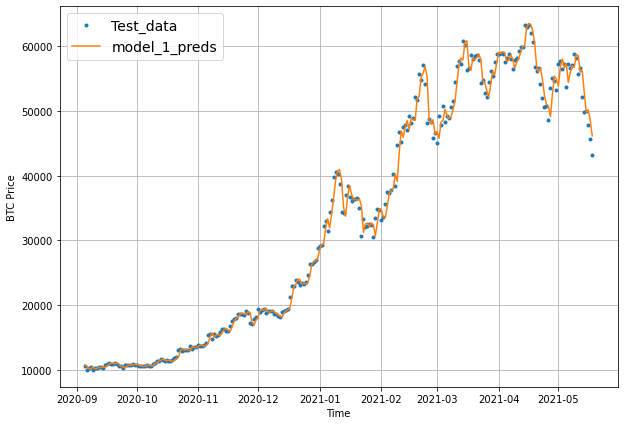

In [42]:
# Visualizing the result

offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

### Model 2: Dense (window = 30, horizon = 1)

In [43]:
HORIZON = 1
WINDOW_SIZE = 30

In [44]:
# Make windowed data with appropriate horizon nad window size

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [45]:
# Make train and test windows

train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows,
                                                                               labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [46]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [47]:
# Evaluate model_2 preds

model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 610.0170


610.0169677734375

In [48]:
# Load in best performing model

model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 604.0062


604.0061645507812

In [49]:
# Get forecast predictions

model_2_preds = make_preds(model_2,
                           input_data=test_windows)
model_2_preds[-10:]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([57249.03 , 57983.566, 59209.227, 56703.133, 56625.977, 53535.01 ,
       50775.   , 51294.3  , 48822.95 , 45805.832], dtype=float32)>

In [50]:
# Evaluate results for model_2 prediction

model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)

In [51]:
model_2_results

{'mae': 604.00616,
 'mse': 1300901.1,
 'rmse': 1140.5706,
 'mape': 2.7017002,
 'mase': 1.0558087}

### Model 3: Dense (window = 30, horizon = 7)

In [52]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [53]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [54]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name = "model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [55]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1382.7468


1382.746826171875

In [56]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1231.6667


1231.666748046875

In [57]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[-5:]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[56941.098, 57037.65 , 57998.19 , 56713.81 , 57502.18 , 57515.215,
        57712.215],
       [56945.87 , 56602.383, 58121.18 , 58642.93 , 58926.47 , 57735.47 ,
        57315.176],
       [57605.223, 58757.6  , 57926.266, 60194.426, 59926.195, 59297.152,
        58799.19 ],
       [57899.676, 58147.92 , 58938.26 , 58979.74 , 60067.727, 59616.24 ,
        59006.805],
       [57808.098, 57437.594, 59553.055, 58958.812, 60043.965, 58703.63 ,
        58950.816]], dtype=float32)>

In [58]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  577.72754 ,   353.59195 ,   359.47543 ,   561.48645 ,
          516.33563 ,   540.2046  ,   486.23813 ,   553.563   ,
          500.8854  ,   643.84247 ,   871.87494 ,   893.04877 ,
         1023.08295 ,  1061.0867  ,   682.2904  ,   273.3986  ,
          211.63225 ,   162.49734 ,   200.3628  ,   198.5533  ,
          220.67201 ,   260.96255 ,   357.96017 ,   363.25732 ,
          162.44719 ,    98.9578  ,   118.631905,   133.65381 ,
          219.71443 ,   268.76617 ,   381.2175  ,   434.19135 ,
          455.08237 ,   368.54562 ,   322.69244 ,   339.23325 ,
          441.68066 ,   227.03453 ,   267.8316  ,   151.19783 ,
          474.85107 ,    85.37402 ,   118.73793 ,   153.59055 ,
          175.69344 ,   219.52469 ,    97.66908 ,    99.19176 ,
           79.76172 ,   195.37263 ,   178.36502 ,   259.116   ,
          324.0759  ,   211.57756 ,   253.44469 ,   277.46045 ,
          587.0671  ,   437.07553 ,   419.91092 ,   507.9285  ,
          286.881   ,   199.5657 

### Make our evaluation function work for larger horizon

In [59]:
def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [60]:
# Get model_3 reults

model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1231.6667,
 'mse': 5297759.5,
 'rmse': 1418.4484,
 'mape': 5.64372,
 'mase': 2.191682}

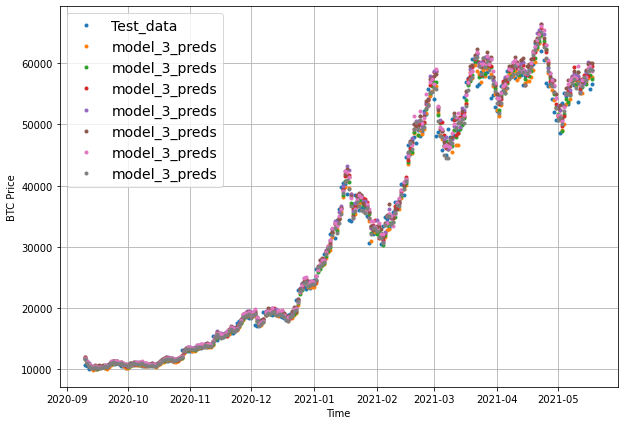

In [61]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

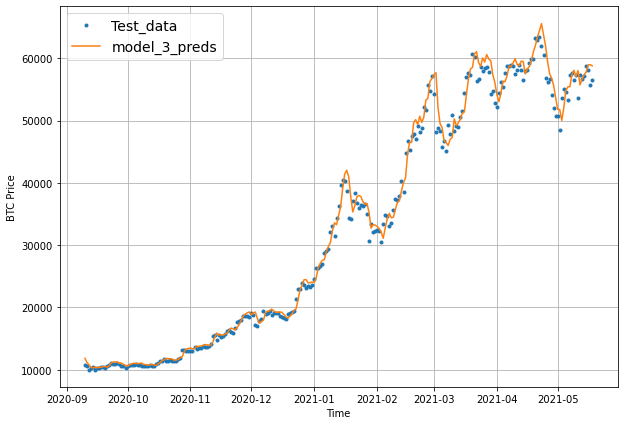

In [62]:
offset = 300
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), format="-", start=offset, label="model_3_preds")

### Which of our model is performing best so far?

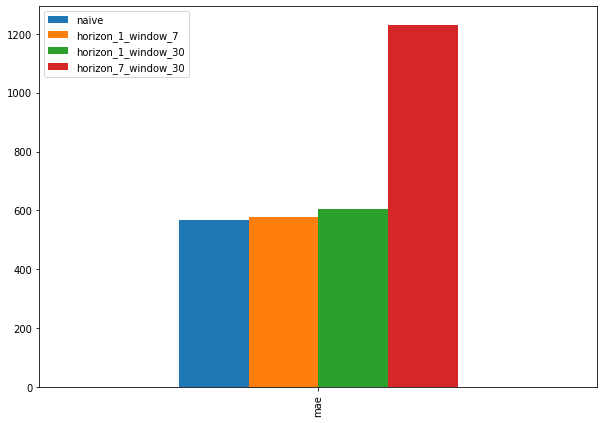

In [63]:
pd.DataFrame({"naive":naive_results["mae"],
              "horizon_1_window_7":model_1_results["mae"],
              "horizon_1_window_30":model_2_results["mae"],
              "horizon_7_window_30":model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

### Model 4: Conv1D

In [64]:
HORIZON = 1
WINDOW_SIZE = 7

In [65]:
# Create windowed dataset

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [66]:
# Create test/train splits

train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [67]:
# Check data sample shapes
train_windows[0].shape

(7,)

In [68]:
# Before we pass our data to conv1D, we have to reshape it to make sure it works

x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with Expanded shape:\n{expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with Expanded shape:
[[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [69]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_Conv1D")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [70]:
model_4.summary()

Model: "model_4_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [71]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_Conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 8ms/step - loss: 572.9401


572.9401245117188

In [72]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:5]

18/18 [==============================] - 0s 5ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8916.174, 8808.029, 9003.181, 8807.77 , 8753.844], dtype=float32)>

In [73]:
# Evaluate predictions

model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 572.9402,
 'mse': 1198186.1,
 'rmse': 1094.6168,
 'mape': 2.5702574,
 'mase': 1.0064973}

### Model 5: RNN (LSTM)

In [74]:
tf.random.set_seed(42)

# Let's an LSTM model with the functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# print(x.shape)
# x= layers.LSTM(128, activation="relu", return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
# print(x.shape)
# Add another optional dense layer
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile the model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
18/18 [==============================] - 6s 223ms/step - loss: 2217.2114 - val_loss: 8477.2344
Epoch 2/100
18/18 [==============================] - 4s 216ms/step - loss: 594.8386 - val_loss: 1802.8306
Epoch 3/100
18/18 [==============================] - 5s 290ms/step - loss: 229.8432 - val_loss: 1255.8169
Epoch 4/100
18/18 [==============================] - 4s 254ms/step - loss: 174.5306 - val_loss: 982.7755
Epoch 5/100
18/18 [==============================] - 4s 215ms/step - loss: 169.5519 - val_loss: 945.7750
Epoch 6/100
18/18 [==============================] - 6s 348ms/step - loss: 167.6879 - val_loss: 927.0482
Epoch 7/100
18/18 [==============================] - 5s 303ms/step - loss: 168.1023 - val_loss: 922.7068
Epoch 8/100
18/18 [==============================] - 6s 330ms/step - loss: 164.6493 - val_loss: 918.6577
Epoch 9/100
18/18 [==============================] - 4s 223ms/step - loss: 163.8666 - val_loss: 912.0812
Epoch 10/100
18/18 [==============================]

In [75]:
# Load in the best version of model 5 and evaluate

model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 1s 9ms/step - loss: 575.1808


575.1807861328125

In [76]:
# Make prediction with our LSTM model

model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 1s 6ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8912.443, 8789.872, 8974.42 , 8800.157, 8778.385, 8743.095,
       8680.061, 8553.662, 8473.089, 8513.093], dtype=float32)>

In [77]:
# Evaluate model 5 preds

model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 575.18085,
 'mse': 1194534.9,
 'rmse': 1092.9478,
 'mape': 2.5883899,
 'mase': 1.0104334}

### Make a multivariate time series

In [78]:
# Lets make a multivariate time series

bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [79]:
# Block reward values

block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

# Block reward dates

block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [80]:
# Get datetime indexes for when to add in different block dates

block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [81]:
# Add block reward column

bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block reward column

bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days: block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


<AxesSubplot:xlabel='Date'>

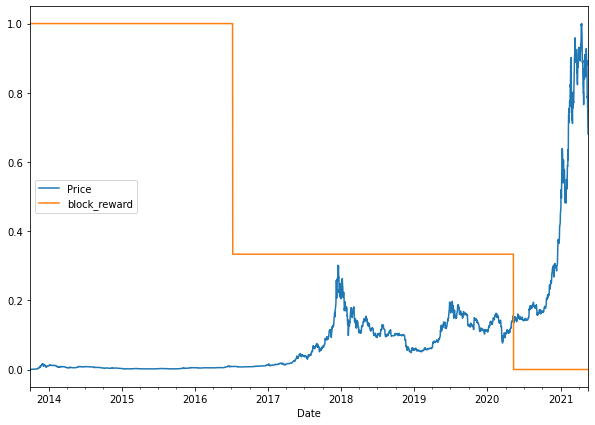

In [82]:
# Plot the block reward/price over time

from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7))

### Making a windowed dataset with pandas

In [82]:
# Setup dataset hyperparameters

HORIZON = 1
WINDOW_SIZE = 7

In [83]:
# Make a copy of the bitcoin historical data with block reward feature

bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns

for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [84]:
# Lets create X & y, remove the Nans and convert to float32 to prevent TensorFlow errors

X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [85]:
# View labels

y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [86]:
# Make train and tests

split_size = int(len(X)*0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

### Model 6: Dense (multivariate time series)

In [87]:
# Make multivariate time series model

tf.random.set_seed(42)
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    # Layers.Dense(128, activation="relu"), # Adding an extra layer here should lead to beating the native model
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [88]:
# Make sure best model is loaded and evaluate

model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 564.8898


564.8898315429688

In [89]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8857.469, 8782.566, 8992.172, 8767.88 , 8785.323, 8722.324,
       8659.417, 8533.103, 8455.426, 8508.308], dtype=float32)>

In [90]:
# Evaluate preds

model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 564.8898,
 'mse': 1160270.5,
 'rmse': 1077.1586,
 'mape': 2.5452483,
 'mase': 0.99235487}

In [91]:
model_1_results

{'mae': 577.7945,
 'mse': 1187824.8,
 'rmse': 1089.8737,
 'mape': 2.5777857,
 'mase': 1.0150249}

### Model 7: N-BEATS algorithm

In [94]:
# Create NBeatsBlock custom layer

class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs takes crae of all the parameters for the parent class
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is theta layerwith linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon]

    return backcast, forecast

In [95]:
# Setup dummy NBeatsBlock layer to represent inouts and outputs

dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [97]:
# Create dummy inputs (have to be same size as input size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [99]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.05759348  0.3533038   0.30096102 -0.33361572  0.16517143  1.1511495
 -0.9043986 ]
Forecast: 0.42734265327453613
